## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [2]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [3]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [4]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [5]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [6]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [7]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [8]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [9]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [10]:
target = 'survived'

In [11]:
vars_num = [var for var in data.columns if data[var].dtypes != 'O']

vars_cat = [var for var in data.columns if data[var].dtypes == 'O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [12]:
# first in numerical variables
data[vars_num].isnull().mean()

pclass      0.000000
survived    0.000000
age         0.200917
sibsp       0.000000
parch       0.000000
fare        0.000764
dtype: float64

In [13]:
# now in categorical variables
data[vars_cat].isnull().mean()


sex         0.000000
cabin       0.774637
embarked    0.001528
title       0.000000
dtype: float64

### Determine cardinality of categorical variables

In [14]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

In [15]:
#Cabin looks like has high cardinality! maybe we should murge or drop it???

### Determine the distribution of numerical variables

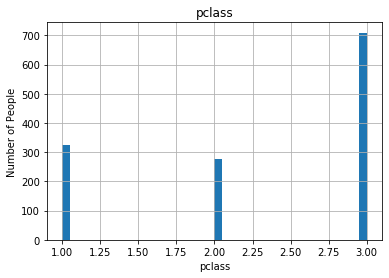

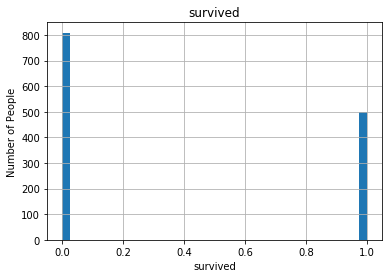

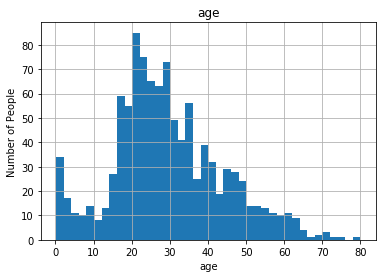

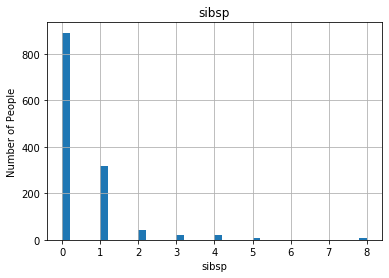

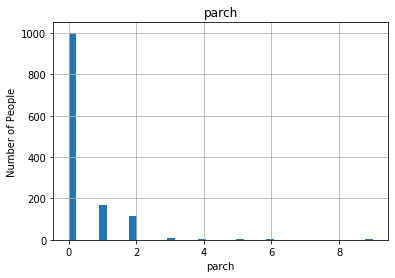

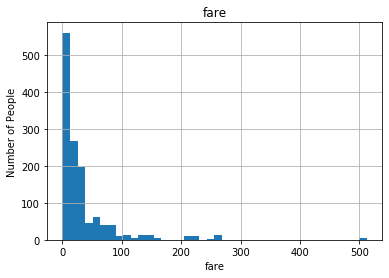

In [16]:
def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins=40)
    plt.ylabel('Number of People')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


for var in vars_num:
    analyse_continuous(data, var)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [18]:
X_train['cabin'] = X_train['cabin'].str.replace('\d+', '')
X_test['cabin'] = X_test['cabin'].str.replace('\d+', '')

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [19]:
X_train

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1118,3,male,25.0000,0,0,7.9250,NaN,S,Mr
44,1,female,41.0000,0,0,134.5000,E,C,Miss
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr
1130,3,female,18.0000,0,0,7.7750,NaN,S,Miss
574,2,male,29.0000,1,0,21.0000,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,NaN,S,Miss
835,3,male,NaN,0,0,8.0500,NaN,S,Mr
1216,3,female,NaN,0,0,7.7333,NaN,Q,Miss
559,2,female,20.0000,0,0,36.7500,NaN,S,Miss


In [20]:
vars_with_na = [
    var for var in X_train.columns
    if X_train[var].isnull().sum() > 0 and X_train[var].dtypes != 'O'
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

age     0.196753
fare    0.000955
dtype: float64

In [21]:
# replace engineer missing values as we described above

for var in vars_with_na:

    # calculate the median using the train set
    median_val = X_train[var].median()

    # add binary missing indicator (in train and test)
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mode
    # (in train and test)
    X_train[var] = X_train[var].fillna(median_val)
    X_test[var] = X_test[var].fillna(median_val)

# check that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

age     0
fare    0
dtype: int64

In [22]:
X_train

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.0000,0,0,7.9250,NaN,S,Mr,0,0
44,1,female,41.0000,0,0,134.5000,E,C,Miss,0,0
1072,3,male,28.0000,0,0,7.7333,NaN,Q,Mr,1,0
1130,3,female,18.0000,0,0,7.7750,NaN,S,Miss,0,0
574,2,male,29.0000,1,0,21.0000,NaN,S,Mr,0,0
...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,NaN,S,Miss,0,0
835,3,male,28.0000,0,0,8.0500,NaN,S,Mr,1,0
1216,3,female,28.0000,0,0,7.7333,NaN,Q,Miss,1,0
559,2,female,20.0000,0,0,36.7500,NaN,S,Miss,0,0


### Replace Missing data in categorical variables with the string **Missing**

In [23]:
vars_with_na = [
    var for var in X_train.columns
    if X_train[var].isnull().sum() > 0 and X_train[var].dtypes == 'O'
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

cabin       0.766953
embarked    0.001910
dtype: float64

In [24]:
for var in vars_with_na:

   
    # replace missing values by the Missing
    # (in train and test)
    X_train[var] = X_train[var].fillna('Missing')
    X_test[var] = X_test[var].fillna('Missing')

# check that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

cabin       0
embarked    0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [25]:
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
X_train[cat_vars]

,sex,cabin,embarked,title
1118,male,Missing,S,Mr
44,female,E,C,Miss
1072,male,Missing,Q,Mr
1130,female,Missing,S,Miss
574,male,Missing,S,Mr
...,...,...,...,...
763,female,Missing,S,Miss
835,male,Missing,S,Mr
1216,female,Missing,Q,Miss
559,female,Missing,S,Miss


In [26]:
X_train['cabin']

1118    Missing
44            E
1072    Missing
1130    Missing
574     Missing
         ...   
763     Missing
835     Missing
1216    Missing
559     Missing
684     Missing
Name: cabin, Length: 1047, dtype: object

In [27]:
#cabin looks problematic it should be droped but the notebook does not instruct it so i wil lleave it

In [28]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)
    return tmp[tmp > rare_perc].index

for var in cat_vars:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [29]:
X_train[cat_vars]

,sex,cabin,embarked,title
1118,male,Missing,S,Mr
44,female,Rare,C,Miss
1072,male,Missing,Q,Mr
1130,female,Missing,S,Miss
574,male,Missing,S,Mr
...,...,...,...,...
763,female,Missing,S,Miss
835,male,Missing,S,Mr
1216,female,Missing,Q,Miss
559,female,Missing,S,Miss


In [30]:
# this function will assign discrete values to the strings of the variables,


def replace_categories(train, test, var):

    # order the categories in a variable from that with the lowest
    labels = train[var].unique().tolist()
    
    
    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(labels, 0)}
    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [31]:
for var in cat_vars:
    replace_categories(X_train, X_test, var)


In [32]:
X_train[cat_vars]

,sex,cabin,embarked,title
1118,0,0,0,0
44,1,1,1,1
1072,0,0,2,0
1130,1,0,0,1
574,0,0,0,0
...,...,...,...,...
763,1,0,0,1
835,0,0,0,0
1216,1,0,2,1
559,1,0,0,1


### Scale the variables

- Use the standard scaler from Scikit-learn

In [33]:
X_train

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,0,25.0000,0,0,7.9250,0,0,0,0,0
44,1,1,41.0000,0,0,134.5000,1,1,1,0,0
1072,3,0,28.0000,0,0,7.7333,0,2,0,1,0
1130,3,1,18.0000,0,0,7.7750,0,0,1,0,0
574,2,0,29.0000,1,0,21.0000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
763,3,1,0.1667,1,2,20.5750,0,0,1,0,0
835,3,0,28.0000,0,0,8.0500,0,0,0,1,0
1216,3,1,28.0000,0,0,7.7333,0,2,1,1,0
559,2,1,20.0000,0,0,36.7500,0,0,1,0,0


In [34]:
train_vars = X_train.columns

# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[train_vars]) 

# transform the train and test set
X_train[train_vars] = scaler.transform(X_train[train_vars])

X_test[train_vars] = scaler.transform(X_test[train_vars])

In [35]:
X_train

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,0.835808,-0.761042,-0.370162,-0.478911,-0.455423,-0.504782,-0.511187,-0.587208,-0.754831,-0.494921,-0.03092
44,-1.542157,1.313987,0.904029,-0.478911,-0.455423,1.971555,1.150965,0.930834,0.276903,-0.494921,-0.03092
1072,0.835808,-0.761042,-0.131251,-0.478911,-0.455423,-0.508533,-0.511187,2.448876,-0.754831,2.020526,-0.03092
1130,0.835808,1.313987,-0.927621,-0.478911,-0.455423,-0.507717,-0.511187,-0.587208,0.276903,-0.494921,-0.03092
574,-0.353174,-0.761042,-0.051614,0.434422,-0.455423,-0.248980,-0.511187,-0.587208,-0.754831,-0.494921,-0.03092
...,...,...,...,...,...,...,...,...,...,...,...
763,0.835808,1.313987,-2.347810,0.434422,1.910970,-0.257295,-0.511187,-0.587208,0.276903,-0.494921,-0.03092
835,0.835808,-0.761042,-0.131251,-0.478911,-0.455423,-0.502337,-0.511187,-0.587208,-0.754831,2.020526,-0.03092
1216,0.835808,1.313987,-0.131251,-0.478911,-0.455423,-0.508533,-0.511187,2.448876,0.276903,2.020526,-0.03092
559,-0.353174,1.313987,-0.768347,-0.478911,-0.455423,0.059156,-0.511187,-0.587208,0.276903,-0.494921,-0.03092


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [36]:
# set up the model
# remember to set the random_state / seed

log_model = LogisticRegression(tol=0.0005, random_state=0)

# train the model

log_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0005, verbose=0,
                   warm_start=False)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [37]:
#accuracy_score
accuracy_score(y_test, log_model.predict(X_test))



0.8129770992366412

In [41]:
# roc_auc_score
roc_auc_score(y_test, log_model.predict(X_test))

0.7875308641975309

C:\Users\20185349\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


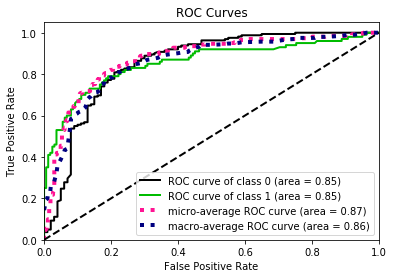

In [40]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_test
y_probas =  log_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**